
# **Preface**

# **Title**

**Prognostic Value of Baseline and Pre-Lymphodepletion PET/CT Imaging in DLBCL Patients Undergoing CAR T-Cell Therapy**

### **Motivation** 

**Chimeric Antigen Receptor (CAR) T-cell therapy has emerged as a transformative treatment modality for hematologic malignancies, demonstrating remarkable efficacy in diffuse large B-cell lymphoma (DLBCL) [1], [2], [3], [4], [5]. However, bridging therapy is frequently required to control disease burden during the manufacturing period before CAR T-cell infusion [1], [6], [7], [8], [9]. One way to measure the efficacy of bridging therapy on CAR T-cell therapy is through 18F-Fluorodeoxyglucose Positron Emission Tomography/Computerized Tomography (18F-FDG PET/CT) imaging. Current literature predominantly focuses on measuring conventional PET metrics such as metabolic active tumor volume (MATV) and standardized uptake value (SUVmax) at single timepoints, rather than employing comprehensive radiomic analysis of dynamic changes [10], [11], [12] . The prognostic value of high-dimensional radiomic features and their temporal evolution (delta radiomics) between baseline and pre-lymphodepletion chemotherapy (pre-LD) scans remains largely unexplored in the CAR T-cell therapy context [11].**

### **Strategic goals**

**We aim to assess whether baseline, pre-LD or delta radiomic profiles (extracted during the bridging period) provide superior prognostic value compared to conventional clinical variables for predicting treatment response, toxicity, progression-free survival, and overall survival.**

**Starting point**

**Current literature predominantly focuses on conventional PET metrics such as metabolic active tumor volume (MATV) and standardized uptake value (SUVmax) at single timepoints, rather than employing comprehensive radiomic analysis of dynamic changes [13]. Preliminary evidence suggests reduced MATV prior to infusion correlates with improved OS (Overall Survival) and TTP (Time To Progression) [12], [14]. Few studies have systematically assessed delta radiomic features, and almost none have explored high-dimensional changes in a CAR T-cell cohort [13], [15]. Bridging strategies (systemic therapy, radiotherapy, or combinations) may influence imaging dynamics, but their detailed prognostic impact remains unclear [16], [17].**

### **Expected results (Hypothesis)**

**We hypothesize that comprehensive delta radiomic analysis will demonstrate enhanced predictive capability compared to conventional single-timepoint metrics.**

### **Purpose of this notebook**

**During this course project, we worked on semi-manually segmenting the lesions using PET/CT scan images, with the help of the lesion report, created by radiologists involved, for each patient.**

**After this stage, we received the clinical data, which includes factors such as: age, gender, dates of important events, etc.**

**In the end, this notebook is dedicated to preprocessing, combining the radiomics data extracted from the images, and the clinical data, and then finally, running suitable analysis on them to test our hypothesis.**

**The following sections summarize the modeling approaches explored in this notebook and provide a high-level interpretation of their results before presenting the detailed implementation.**



## **Logistic Regression Models**

Logistic regression was used as an interpretable baseline model to assess the prognostic value of clinical and radiomics features in this cohort. Given the limited sample size (n = 30) and the high dimensionality of the feature space, there is a substantial risk of overfitting, particularly in the presence of correlated radiomic variables.

To mitigate this, multiple regularization strategies were evaluated, including L1, L2, and Elastic Net penalties. These approaches were combined with different feature sets (clinical variables alone, and combinations of clinical and radiomics features) in order to assess model stability and sensitivity to regularization under small-sample conditions.

Across the evaluated configurations, model performance was highly variable and strongly dependent on both the selected feature set and the applied regularization. In several cases, L1 regularization led to overly sparse solutions, effectively removing most or all features from the model, which resulted in poor predictive performance. In contrast, L2 regularization demonstrated more stable behavior across feature sets, although test performance remained modest and inconsistent.

Importantly, accuracy and AUC values observed on the training data were consistently higher than those obtained on the test data, indicating overfitting despite the use of regularization. These findings highlight the limitations of applying parametric models such as logistic regression to high-dimensional radiomics data in very small cohorts. Overall, the results obtained from logistic regression should be interpreted as exploratory, providing insight into model behavior rather than evidence of reliable prognostic performance.



## **K-Nearest Neighbors (KNN) Analysis**

To further explore the separability of patient outcome classes in a non-parametric setting, the k-nearest neighbors (KNN) algorithm was applied to the same feature sets. Unlike logistic regression, KNN does not rely on an explicit parametric form and is instead sensitive to feature scaling, dimensionality, and distance relationships between samples.

Models based solely on clinical variables were unable to effectively distinguish between patients with favorable and unfavorable short-term outcomes, yielding performance close to chance level. Similarly, models incorporating post-treatment or delta radiomics features generally performed poorly and exhibited signs of overfitting, failing to reliably classify deceased patients.

In contrast, combining clinical variables with pre-treatment quantitative imaging features resulted in improved apparent classification performance in some configurations. This suggests that baseline radiomic features may capture aspects of tumor burden, spatial heterogeneity, or biological aggressiveness that are not fully reflected by standard clinical parameters alone.

However, the performance of KNN models was highly sensitive to the specific train–test split. Even minor changes in patient allocation led to substantial variation in accuracy and AUC values, reflecting the inherent instability of distance-based methods in high-dimensional spaces with very limited sample sizes. This behavior is consistent with the curse of dimensionality, where increasing feature dimensionality reduces the meaningfulness of distance-based similarity measures.

Given these limitations, the KNN results should be interpreted with caution. While they suggest that pre-treatment radiomic features may contain additional prognostic information, the observed performance is best regarded as exploratory and hypothesis-generating rather than indicative of robust predictive capability.



## **Overall Interpretation and Limitations**

Results from both logistic regression and KNN analyses indicate that pre-treatment radiological features may be more informative than clinical assessment alone or post-treatment imaging. However, all evaluated approaches were affected by substantial limitations, including model instability, susceptibility to overfitting, and strong dependence on how the available data were split into training and testing sets.

Methodological studies have consistently shown that small sample sizes and inadequate validation strategies are major contributors to bias and poor reproducibility in radiomics-based machine learning research [19,20,22]. In the present study, the combination of high-dimensional feature spaces and a limited number of patients severely constrains the reliability and generalizability of the findings.

Accordingly, the results presented here should be considered exploratory and primarily useful for hypothesis generation. Future studies should involve substantially larger, multi-center cohorts and adopt more robust validation strategies, such as repeated or nested cross-validation and external validation on independent datasets, to reliably assess the prognostic value of combining radiomics and machine learning in the context of CAR T-cell therapy.




------------

# **1. Setup and Imports**
### **1.1: Import Required Libraries**

In [1]:
import sys
import os
sys.path.insert(0, os.getcwd())

import yaml
from pathlib import Path
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

### **1.2: Import Preprocessing Functions**

In [2]:
# Import preprocessing
from preprocessor import (
    calculate_delta_radiomics,
    clean_and_suffix_radiomics,
    prepare_and_clean_clinical_data,
    convert_clinical_data_types,
    remove_zero_variance_features,
    impute_clinical_missing_values,
    drop_clinical_date_columns,
    create_all_modeling_datasets
)

print("All preprocessing functions imported")

All preprocessing functions imported


### **1.3: Load Configuration File**

In [3]:
# Load configuration from YAML file
CONFIG_PATH = Path("..") / "config.yaml"

with open(CONFIG_PATH, "r") as f:
    config = yaml.safe_load(f)

# Extract paths
DATA_DIR = config["data"]["root_dir"]
CLINICAL_DIR = config["clinical"]["root_dir"]
CLINICAL_FILE = config["clinical"]["main_file"]
CLINICAL_PATH = os.path.join(CLINICAL_DIR, CLINICAL_FILE)

print(" Configuration loaded")
print(f"   Radiomics data: {DATA_DIR}")
print(f"   Clinical data: {CLINICAL_PATH}")

 Configuration loaded
   Radiomics data: D:/DSLS/Omics2/modelling/modelling_data
   Clinical data: D:/DSLS/Omics2/modelling/clinical_data\clinical_data.xlsx


### **1.4: Load Raw Clinical Data**

In [4]:
# Read clinical data from Excel file
clinical_data = pd.read_excel(CLINICAL_PATH)

print(" Clinical data loaded")
print(f"   Shape: {clinical_data.shape}")
print(f"   Patients: {clinical_data.shape[0]}")
print(f"   Variables: {clinical_data.shape[1]}")
print(f"\n   First few patient IDs:")
print(f"   {clinical_data['record_id'].values[:5]}")

 Clinical data loaded
   Shape: (69, 275)
   Patients: 69
   Variables: 275

   First few patient IDs:
   ['Record ID' 'FTC-UMCG-0001' 'FTC-UMCG-0002' 'FTC-UMCG-0003'
 'FTC-UMCG-0004']


---

# **2. RADIOMICS DATA PROCESSING**

### **2.1: Calculate Delta Radiomics (Time B - Time A)**

In [5]:
print("="*70)
print("STEP 1: CALCULATING DELTA RADIOMICS")
print("="*70)
print("Reading radiomics files from patient folders...")
print("Extracting 'suv2.5' segmentation features...")
print("Computing delta = Time B - Time A")
print("-"*70)

# Calculate radiomics for all time points
delta_radiomics_results, a_radiomics, b_radiomics = calculate_delta_radiomics(DATA_DIR)

print("\n Delta radiomics calculated")
print(f"   Delta radiomics: {delta_radiomics_results.shape}")
print(f"   Time A radiomics: {a_radiomics.shape}")
print(f"   Time B radiomics: {b_radiomics.shape}")
print(f"   Patients processed: {delta_radiomics_results.shape[0]}")

# Show sample of delta radiomics
print(f"\n   Sample delta features for first patient:")
sample_patient = delta_radiomics_results.index[0]
sample_features = list(delta_radiomics_results.loc[sample_patient].items())[:3]
for feature, value in sample_features:
    print(f"      {feature}: {value:.4f}")

STEP 1: CALCULATING DELTA RADIOMICS
Reading radiomics files from patient folders...
Extracting 'suv2.5' segmentation features...
Computing delta = Time B - Time A
----------------------------------------------------------------------
--- Processing 005 ---
Successfully calculated radiomics and delta radiomics for 005.
--- Processing 006 ---
Successfully calculated radiomics and delta radiomics for 006.
--- Processing 007 ---
Successfully calculated radiomics and delta radiomics for 007.
--- Processing 008 ---
Successfully calculated radiomics and delta radiomics for 008.
--- Processing 009 ---
Successfully calculated radiomics and delta radiomics for 009.
--- Processing 010 ---
Successfully calculated radiomics and delta radiomics for 010.
--- Processing 011 ---
Successfully calculated radiomics and delta radiomics for 011.
--- Processing 013 ---
Successfully calculated radiomics and delta radiomics for 013.
--- Processing 014 ---
Successfully calculated radiomics and delta radiomics f

### **2.2: Clean Radiomics Data**

In [6]:
print("\n" + "="*70)
print("STEP 2: CLEANING RADIOMICS DATA")
print("="*70)
print("Removing columns with ANY missing values...")
print("Resetting index and converting patient IDs to integers...")
print("Adding suffixes '_a' and '_b' to time-specific features...")
print("-"*70)

# Clean all radiomics dataframes
delta_radiomics_results, a_radiomics, b_radiomics = clean_and_suffix_radiomics(
    delta_radiomics_results, 
    a_radiomics, 
    b_radiomics
)

print("\n Radiomics data cleaned")
print(f"   Delta radiomics: {delta_radiomics_results.shape}")
print(f"      → Complete features: {delta_radiomics_results.shape[1] - 1}")  # -1 for 'id' column
print(f"   Time A radiomics: {a_radiomics.shape}")
print(f"      → Features with '_a' suffix: {a_radiomics.shape[1] - 1}")
print(f"   Time B radiomics: {b_radiomics.shape}")
print(f"      → Features with '_b' suffix: {b_radiomics.shape[1] - 1}")

print(f"\n   Patient IDs available:")
print(f"   {sorted(delta_radiomics_results['id'].values)}")


STEP 2: CLEANING RADIOMICS DATA
Removing columns with ANY missing values...
Resetting index and converting patient IDs to integers...
Adding suffixes '_a' and '_b' to time-specific features...
----------------------------------------------------------------------

 Radiomics data cleaned
   Delta radiomics: (31, 44)
      → Complete features: 43
   Time A radiomics: (31, 44)
      → Features with '_a' suffix: 43
   Time B radiomics: (31, 44)
      → Features with '_b' suffix: 43

   Patient IDs available:
   [5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 22, 23, 24, 26, 28, 31, 46, 47, 48, 50, 52, 55, 61, 64, 68, 70, 77, 95]


In this step, radiomics data extracted at baseline (Time A) and pre-lymphodepletion (Time B) were cleaned and prepared for modelling.

First, radiomic features with any missing values were removed. This complete-case filtering was applied to avoid introducing missing values into downstream machine-learning models and to ensure that all patients shared the same feature set.

Patient identifiers were then standardised and converted to integer format to allow reliable merging with the clinical dataset. The index was reset to maintain consistent row alignment across all data tables.

Finally, time-specific suffixes were added to distinguish features extracted at different timepoints. Baseline radiomics features were assigned the suffix _a, while pre-lymphodepletion features were assigned _b.

After these preprocessing steps, 43 radiomic features were retained for each timepoint, along with 43 corresponding delta radiomics features, resulting in a clean and consistent radiomics dataset suitable for subsequent modelling

----

# **3. CLINICAL DATA PROCESSING**

In this section, we prepare the clinical dataset for machine learning analysis and align it with the radiomics features extracted in the previous steps. The main objective is to construct a clean, consistent modelling table that can be safely used for predictive modelling.

To achieve this, clinical records are matched with radiomics data using patient identifiers, ensuring that only patients with data available in both sources are retained. A series of preprocessing steps is then applied to reduce noise and minimise the risk of information leakage. These steps include removing irrelevant or redundant variables, encoding categorical features, handling missing values, and standardising data types.

Special attention is given to excluding outcome-dependent variables and highly correlated features that could artificially inflate model performance. After preprocessing, the final clinical dataset contains only baseline variables that are available prior to CAR T-cell therapy and are therefore appropriate for use in machine learning models.

### **3.1: Prepare and Filter Clinical Data**

In [7]:
print("\n" + "="*70)
print("STEP 3: PREPARING CLINICAL DATA")
print("="*70)
print("Creating cleaned patient ID column...")
print("Filtering for patients present in BOTH clinical and radiomics data...")
print("Dropping columns with all NaN values...")
print("Removing unnecessary columns (factors, comments, locations, etc.)...")
print("One-hot encoding disease diagnosis...")
print("Dropping columns with >50% missing values...")
print("-"*70)

# Prepare clinical data
clinic_data_cleaned = prepare_and_clean_clinical_data(
    clinical_data, 
    delta_radiomics_results
)

print("\n Clinical data prepared")
print(f"   Shape: {clinic_data_cleaned.shape}")
print(f"   Patients (matched with radiomics): {clinic_data_cleaned.shape[0]}")
print(f"   Variables remaining: {clinic_data_cleaned.shape[1]}")

print(f"\n   Key columns retained:")
key_cols = ['scr_sex', 'scr_age', 'scr_bmi', 'surv_status', 'DLBCL', 'tFL']
for col in key_cols:
    if col in clinic_data_cleaned.columns:
        print(f"      ✓ {col}")


STEP 3: PREPARING CLINICAL DATA
Creating cleaned patient ID column...
Filtering for patients present in BOTH clinical and radiomics data...
Dropping columns with all NaN values...
Removing unnecessary columns (factors, comments, locations, etc.)...
One-hot encoding disease diagnosis...
Dropping columns with >50% missing values...
----------------------------------------------------------------------

 Clinical data prepared
   Shape: (30, 113)
   Patients (matched with radiomics): 30
   Variables remaining: 113

   Key columns retained:
      ✓ scr_sex
      ✓ scr_age
      ✓ scr_bmi
      ✓ surv_status
      ✓ DLBCL
      ✓ tFL


After aligning clinical records with the radiomics dataset, a total of 30 patients were retained for analysis.

All included patients had complete radiomics data. One patient (ID 95) was excluded due to missing clinical information.

This final cohort was used consistently across all subsequent modelling experiments.


### **3.2: Convert Data Types**

In [8]:
print("\n" + "="*70)
print("STEP 4: CONVERTING DATA TYPES")
print("="*70)
print("Converting date columns to datetime...")
print("Converting numeric strings (fixing comma/period typos)...")
print("Ensuring proper data types for analysis...")
print("-"*70)

# Convert data types
clinic_data_cleaned = convert_clinical_data_types(clinic_data_cleaned)

print("\n Data types converted")
print(f"   Shape: {clinic_data_cleaned.shape}")
print(f"\n   Data type summary:")
print(f"      Numeric columns: {clinic_data_cleaned.select_dtypes(include=np.number).shape[1]}")
print(f"      Date columns: {clinic_data_cleaned.select_dtypes(include='datetime').shape[1]}")


STEP 4: CONVERTING DATA TYPES
Converting date columns to datetime...
Converting numeric strings (fixing comma/period typos)...
Ensuring proper data types for analysis...
----------------------------------------------------------------------
Applying general type conversion...

Automatic type conversion complete.

 Data types converted
   Shape: (30, 113)

   Data type summary:
      Numeric columns: 99
      Date columns: 14


nsure compatibility with downstream modelling, all clinical variables were converted to appropriate data types. Date-related fields were parsed into datetime format, while numeric values that were stored as strings were corrected and cast to numeric types.

This step was performed prior to feature selection to guarantee consistent handling of variables and to prevent technical errors during subsequent preprocessing and modelling steps.

### **3.3: Remove Zero Variance Features**

In [9]:
print("\n" + "="*70)
print("STEP 5: REMOVING ZERO VARIANCE FEATURES")
print("="*70)
print("Identifying features with zero variance...")
print("These features have the same value for all patients...")
print("Removing them as they provide no predictive information...")
print("-"*70)

# Calculate variance before removal
variances_before = clinic_data_cleaned.select_dtypes(include=np.number).var()
zero_var_features = variances_before[variances_before == 0].index.tolist()

print(f"\n   Zero variance features found: {len(zero_var_features)}")
if zero_var_features:
    print(f"   Examples: {zero_var_features[:5]}")

# Remove zero variance features
clinic_data_cleaned = remove_zero_variance_features(clinic_data_cleaned)

print("\n Zero variance features removed")
print(f"   Shape: {clinic_data_cleaned.shape}")
print(f"   Features removed: {len(zero_var_features)}")
print(f"   Features remaining: {clinic_data_cleaned.shape[1]}")


STEP 5: REMOVING ZERO VARIANCE FEATURES
Identifying features with zero variance...
These features have the same value for all patients...
Removing them as they provide no predictive information...
----------------------------------------------------------------------

   Zero variance features found: 42
   Examples: ['indication_extran_site_loc___3', 'indication_extran_site_loc___21', 'indication_extran_site_loc___4', 'indication_extran_site_loc___6', 'indication_extran_site_loc___8']

 Zero variance features removed
   Shape: (30, 71)
   Features removed: 42
   Features remaining: 71


In this step, we removed clinical features with zero variance, meaning variables that had the same value for all patients. Such features do not contain any discriminative information and therefore cannot contribute to outcome prediction.

Removing zero-variance features reduces noise, simplifies the feature space, and improves model stability, which is particularly important given the small sample size. After this filtering step, only features with meaningful variability across patients were retained for downstream modelling

### **3.4: Impute Missing Values**

In [10]:
print("\n" + "="*70)
print("STEP 6: IMPUTING MISSING VALUES")
print("="*70)
print("Filling missing numeric values with column median...")
print("This preserves data distribution while handling missingness...")
print("-"*70)

# Count missing values before imputation
missing_before = clinic_data_cleaned.isna().sum().sum()
print(f"\n   Missing values before imputation: {missing_before}")

# Impute missing values
clinic_data_cleaned = impute_clinical_missing_values(clinic_data_cleaned)

# Count missing values after imputation
missing_after = clinic_data_cleaned.isna().sum().sum()
print(f"   Missing values after imputation: {missing_after}")

print("\n Missing values imputed")
print(f"   Shape: {clinic_data_cleaned.shape}")
print(f"   Values imputed: {missing_before - missing_after}")


STEP 6: IMPUTING MISSING VALUES
Filling missing numeric values with column median...
This preserves data distribution while handling missingness...
----------------------------------------------------------------------

   Missing values before imputation: 117
   Missing values after imputation: 61

 Missing values imputed
   Shape: (30, 71)
   Values imputed: 56


In this step, remaining missing values in the clinical dataset were handled using median imputation. Only numeric variables were considered for imputation.

Median imputation was chosen as a simple and robust strategy that preserves the overall distribution of each variable while limiting the influence of extreme values, which is particularly important in small datasets.

After this step, the dataset contained no missing values in numeric features and was suitable for downstream machine learning analysis

### **3.5: Drop Date Columns**

In [11]:
print("\n" + "="*70)
print("STEP 7: REMOVING DATE COLUMNS")
print("="*70)
print("Removing date-related columns...")
print("These are not suitable for machine learning models...")
print("-"*70)

# Identify date columns before removal
date_cols_before = [col for col in clinic_data_cleaned.columns if 'date' in col.lower()]
print(f"\n   Date columns to remove: {len(date_cols_before)}")

# Drop date columns
clinic_data_cleaned = drop_clinical_date_columns(clinic_data_cleaned)

print("\n Date columns removed")
print(f"   Shape: {clinic_data_cleaned.shape}")
print(f"   Columns removed: {len(date_cols_before)}")


STEP 7: REMOVING DATE COLUMNS
Removing date-related columns...
These are not suitable for machine learning models...
----------------------------------------------------------------------

   Date columns to remove: 9

 Date columns removed
   Shape: (30, 55)
   Columns removed: 9


<!-- ### **3.6: Invert Survival Status** -->

----

# **4. CREATE MODELING DATASETS**

### **4.1: Generate All Dataset Combinations**

In [12]:
print("\n" + "="*70)
print("STEP 8: CREATING MODELING DATASETS")
print("="*70)
print("Combining clinical and radiomics data in different ways...")
print("Creating 4 dataset variations:")
print("   X0: Clinical features only")
print("   X1: Clinical + Time A radiomics")
print("   X2: Clinical + Time B radiomics")
print("   X3: Clinical + Delta radiomics (B - A)")
print("-"*70)

# Create all modeling datasets
datasets = create_all_modeling_datasets(
    clinic_data_cleaned,
    delta_radiomics_results,
    a_radiomics,
    b_radiomics
)

# Extract datasets
X0_clinical_only = datasets['X0_clinical_only']
X1_clinical_A = datasets['X1_clinical_A']
X2_clinical_B = datasets['X2_clinical_B']
X3_clinical_delta = datasets['X3_clinical_delta']
y = datasets['y']

print("\n All datasets created")
print("\n" + "="*70)
print("FINAL DATASET SUMMARY")
print("="*70)
print(f"\nX0 (Clinical Only):")
print(f"   Shape: {X0_clinical_only.shape}")
print(f"   Features: {X0_clinical_only.shape[1]}")
print(f"   Samples: {X0_clinical_only.shape[0]}")

print(f"\nX1 (Clinical + Time A Radiomics):")
print(f"   Shape: {X1_clinical_A.shape}")
print(f"   Clinical features: {X0_clinical_only.shape[1]}")
print(f"   Radiomics features: {X1_clinical_A.shape[1] - X0_clinical_only.shape[1]}")
print(f"   Total features: {X1_clinical_A.shape[1]}")

print(f"\nX2 (Clinical + Time B Radiomics):")
print(f"   Shape: {X2_clinical_B.shape}")
print(f"   Clinical features: {X0_clinical_only.shape[1]}")
print(f"   Radiomics features: {X2_clinical_B.shape[1] - X0_clinical_only.shape[1]}")
print(f"   Total features: {X2_clinical_B.shape[1]}")

print(f"\nX3 (Clinical + Delta Radiomics):")
print(f"   Shape: {X3_clinical_delta.shape}")
print(f"   Clinical features: {X0_clinical_only.shape[1]}")
print(f"   Delta features: {delta_radiomics_results.shape[1] - 1}")
print(f"   Time A features: {a_radiomics.shape[1] - 1}")
print(f"   Time B features: {b_radiomics.shape[1] - 1}")
print(f"   Total features: {X3_clinical_delta.shape[1]}")

print(f"\nTarget Variable (y):")
print(f"   Shape: {y.shape}")
print(f"   Distribution: {dict(y.value_counts())}")

print("\n" + "="*70)
print(" PREPROCESSING COMPLETE - READY FOR MODELING")
print("="*70)


STEP 8: CREATING MODELING DATASETS
Combining clinical and radiomics data in different ways...
Creating 4 dataset variations:
   X0: Clinical features only
   X1: Clinical + Time A radiomics
   X2: Clinical + Time B radiomics
   X3: Clinical + Delta radiomics (B - A)
----------------------------------------------------------------------

PREPARING DATA

 All datasets created

FINAL DATASET SUMMARY

X0 (Clinical Only):
   Shape: (30, 53)
   Features: 53
   Samples: 30

X1 (Clinical + Time A Radiomics):
   Shape: (30, 97)
   Clinical features: 53
   Radiomics features: 44
   Total features: 97

X2 (Clinical + Time B Radiomics):
   Shape: (30, 97)
   Clinical features: 53
   Radiomics features: 44
   Total features: 97

X3 (Clinical + Delta Radiomics):
   Shape: (30, 182)
   Clinical features: 53
   Delta features: 43
   Time A features: 43
   Time B features: 43
   Total features: 182

Target Variable (y):
   Shape: (30,)
   Distribution: {0.0: 16, 1.0: 14}

 PREPROCESSING COMPLETE - REA

In this step, several modelling datasets were constructed to systematically evaluate the added prognostic value of radiomics features.

Four feature sets were defined. The first dataset (X0) included clinical variables only and served as a baseline reference. The second and third datasets (X1 and X2) combined clinical variables with radiomics features extracted at baseline (Time A) and pre-lymphodepletion (Time B), respectively. The fourth dataset (X3) integrated clinical variables with delta radiomics, together with the corresponding Time A and Time B features, to capture both absolute and longitudinal imaging information.

All datasets were constructed using the same patient cohort (n = 30) and were aligned with a binary survival outcome. This design enables a direct and fair comparison of model performance across clinical-only, single-timepoint radiomics, and longitudinal radiomics representations

### **4.2: Verify Data Quality**

In [13]:
print("\n" + "="*70)
print("DATA QUALITY CHECK")
print("="*70)

# Check for missing values
print("\nMissing Values:")
for name, X in [("X0", X0_clinical_only), ("X1", X1_clinical_A), 
                ("X2", X2_clinical_B), ("X3", X3_clinical_delta)]:
    missing = X.isna().sum().sum()
    print(f"   {name}: {missing} missing values")

# Check data types
print("\nData Types (X0 as example):")
print(f"   Numeric columns: {X0_clinical_only.select_dtypes(include=np.number).shape[1]}")
print(f"   Non-numeric columns: {X0_clinical_only.select_dtypes(exclude=np.number).shape[1]}")

# Check target distribution
print("\nTarget Distribution:")
print(f"   Class 0 (Event/Death): {(y == 0).sum()}")
print(f"   Class 1 (Censored/Alive): {(y == 1).sum()}")
print(f"   Balance: {(y == 1).sum() / len(y) * 100:.1f}% positive class")

print("\n Data quality verified - No issues found")


DATA QUALITY CHECK

Missing Values:
   X0: 0 missing values
   X1: 0 missing values
   X2: 0 missing values
   X3: 0 missing values

Data Types (X0 as example):
   Numeric columns: 53
   Non-numeric columns: 0

Target Distribution:
   Class 0 (Event/Death): 16
   Class 1 (Censored/Alive): 14
   Balance: 46.7% positive class

 Data quality verified - No issues found


### **4.3: SAVE PROCESSED DATA**

In [14]:
# Save processed datasets for later use
import pickle

# Save all datasets
with open('preprocessed_datasets.pkl', 'wb') as f:
    pickle.dump({
        'X0': X0_clinical_only,
        'X1': X1_clinical_A,
        'X2': X2_clinical_B,
        'X3': X3_clinical_delta,
        'y': y
    }, f)

print(" Preprocessed datasets saved to 'preprocessed_datasets.pkl'")

 Preprocessed datasets saved to 'preprocessed_datasets.pkl'


After dataset construction, a final data quality check was performed to confirm suitability for modelling.

All modelling datasets (X0–X3) contained no missing values, indicating that preprocessing and imputation steps were applied successfully. In addition, all features were numeric, ensuring full compatibility with machine learning algorithms.

The target variable showed a reasonably balanced distribution, with 16 patients experiencing the event (death) and 14 patients being censored (alive), corresponding to a positive class proportion of 46.7%. Overall, this quality check confirmed that the data were clean, consistent, and ready for downstream predictive modelling

----

# **5. KNN ANALYSIS**

### **Methodology**

In this section, a k-nearest neighbors (KNN) classifier with comprehensive pipeline 
optimization is used to investigate whether clinical and radiomics features can 
predict survival after CAR T-cell therapy. To ensure methodological rigor and 
prevent data leakage, all preprocessing steps—including imputation, feature 
selection, and scaling—were performed within a scikit-learn Pipeline, ensuring 
that transformations are fit exclusively on training data.

**Grid Search and Feature Selection Strategy:**

A grid search with 3-fold stratified cross-validation is performed to optimize 
both the KNN hyperparameters and the feature selection method simultaneously. 

**The search space included:**

  • k (number of neighbors): [3, 5, 7, 9, 11]
  • Feature selection methods: 
    - None (no feature selection)
    - L1 regularization (LogisticRegression with L1 penalty, C ∈ {0.1, 0.5, 1.0})
    - KBest (SelectKBest with f_classif, k ∈ {5, 10, 15})
  • Total combinations tested: 35 per dataset

This approach allowes the pipeline to automatically determine not only the optimal number of neighbors but also whether feature selection was beneficial and, if so, 
which method and parameters performed best on the training data.

**Four different feature configurations are evaluated:**

  • X0: Clinical data alone (53 features)

  • X1: Clinical + pre-treatment radiomics (97 features)

  • X2: Clinical + post-treatment radiomics (97 features)
  
  • X3: Clinical + delta radiomics (182 features)

### **5.1: Prepare KNN Datasets Dictionary**

In [15]:
knn_datasets_dict = {
    "X0: Clinical Only": X0_clinical_only,
    "X1: Clinical + A Radiomics": X1_clinical_A,
    "X2: Clinical + B Radiomics": X2_clinical_B,
    "X3: Clinical + Delta Radiomics": X3_clinical_delta
}

### **5.2: Import modeling**

In [16]:
from knn_classification import (
    knn_pipeline_analysis,
    run_knn_on_all_datasets,    # ← IN IMPORT SHAVAD!
    create_summary_table, 
)
from visualization import (
    plot_individual_knn_pipeline,  # ← INJA HAST!
    plot_knn_comparison
)

print(" KNN and Visulization module imported successfully!")

 KNN module loaded successfully!
 Visualization module loaded successfully!
 KNN and Visulization module imported successfully!


###  **5.3: Run KNN Analysis on All Datasets**

In [17]:
# This runs GridSearch with:
# - k values: [3, 5, 7, 9, 11]
# - Feature selection: [None, L1(C=0.1), L1(C=0.5), L1(C=1.0), KBest(5), KBest(10), KBest(15)]
# - Total: 35 combinations per dataset

knn_results = run_knn_on_all_datasets(
    datasets_dict=knn_datasets_dict,
    y=y,
    test_size=0.2,
    random_state=42
)

print("\n KNN analysis complete!")
print(f"   Total datasets tested: {len(knn_results)}")



PIPELINE STRUCTURE
Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('selector', FeatureSelector()),  # L1, KBest, or None
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

 NO DATA LEAKAGE - All preprocessing in Pipeline!
  GridSearch on full Pipeline
  Feature Selection (L1 + KBest)

  KNN PIPELINE ANALYSIS: X0: Clinical Only
  Samples: 30, Features: 53

   Split: Train=24, Test=6
     Train: 13 survived, 11 died
     Test:  3 survived, 3 died

   Running GridSearchCV with Pipeline...
     Testing 35 combinations...
Fitting 3 folds for each of 35 candidates, totalling 105 fits

   GridSearch Complete!

   BEST PARAMETERS:
     k = 3
     Method = KBest
     Params = k=5
     Features: 53 → 5
     CV Accuracy: 0.625

   Making predictions...

   Test Performance:
     Accuracy: 0.500, AUC: 0.667, F1: 0.400

   Classification Report:
              precision    recall  f1-score   support

    Survived       0.50      0.67      0.57         3
   

### **5.4: KNN with GridSearch (Best Parameters)**

**(Visualize Individual KNN Results)**

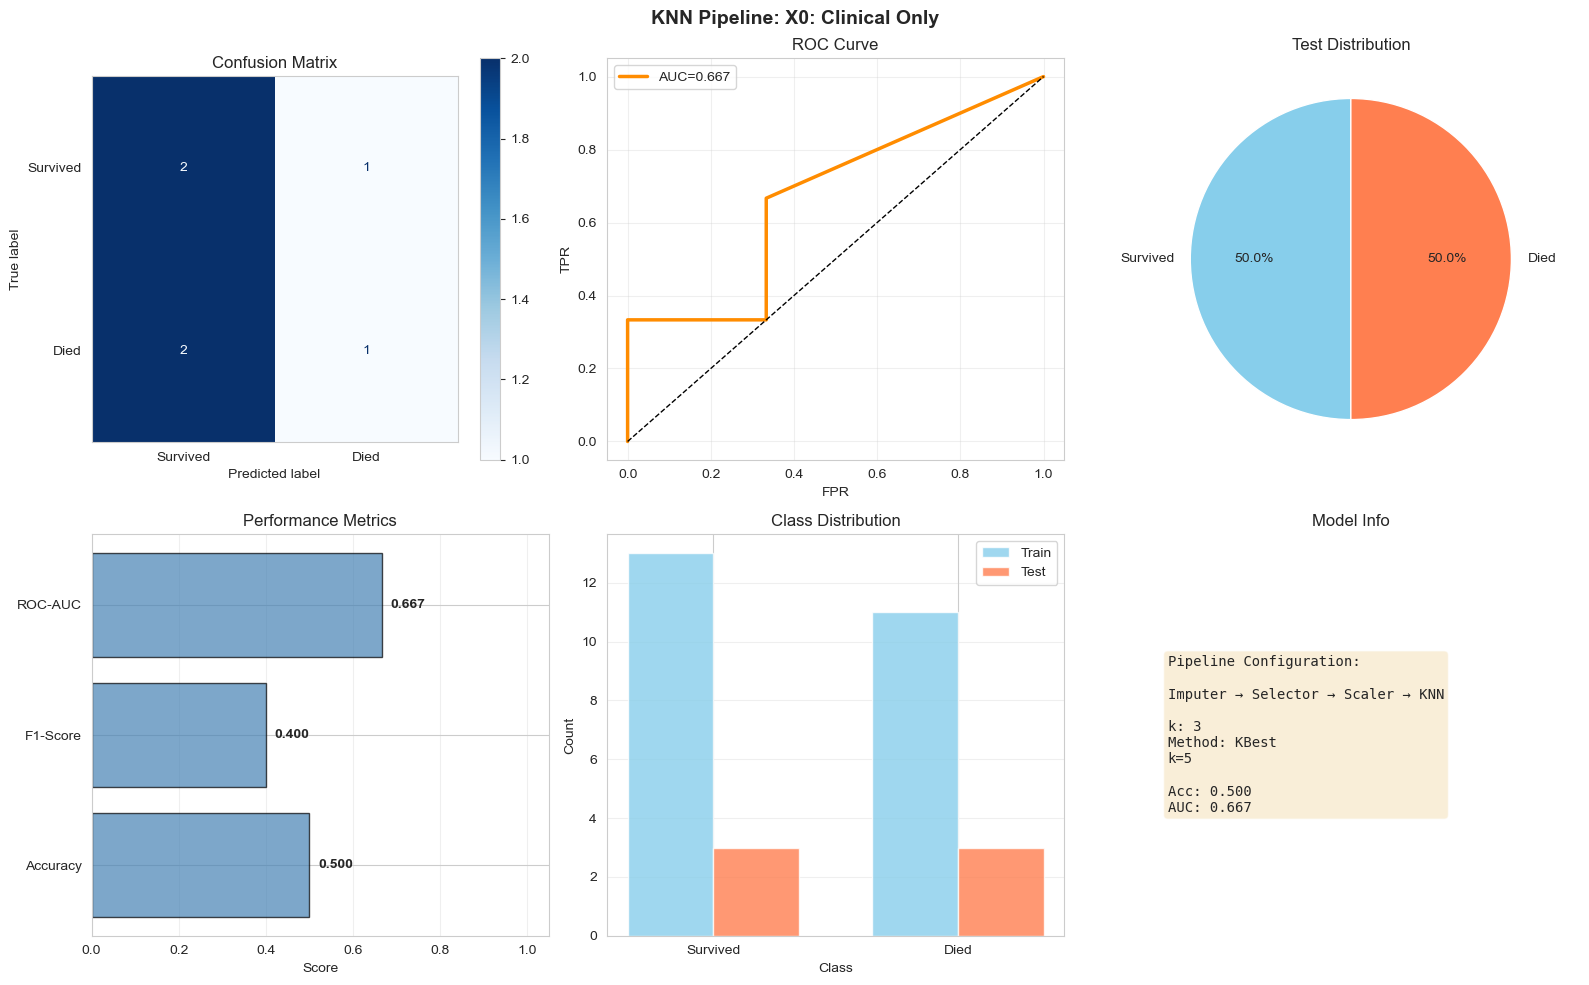

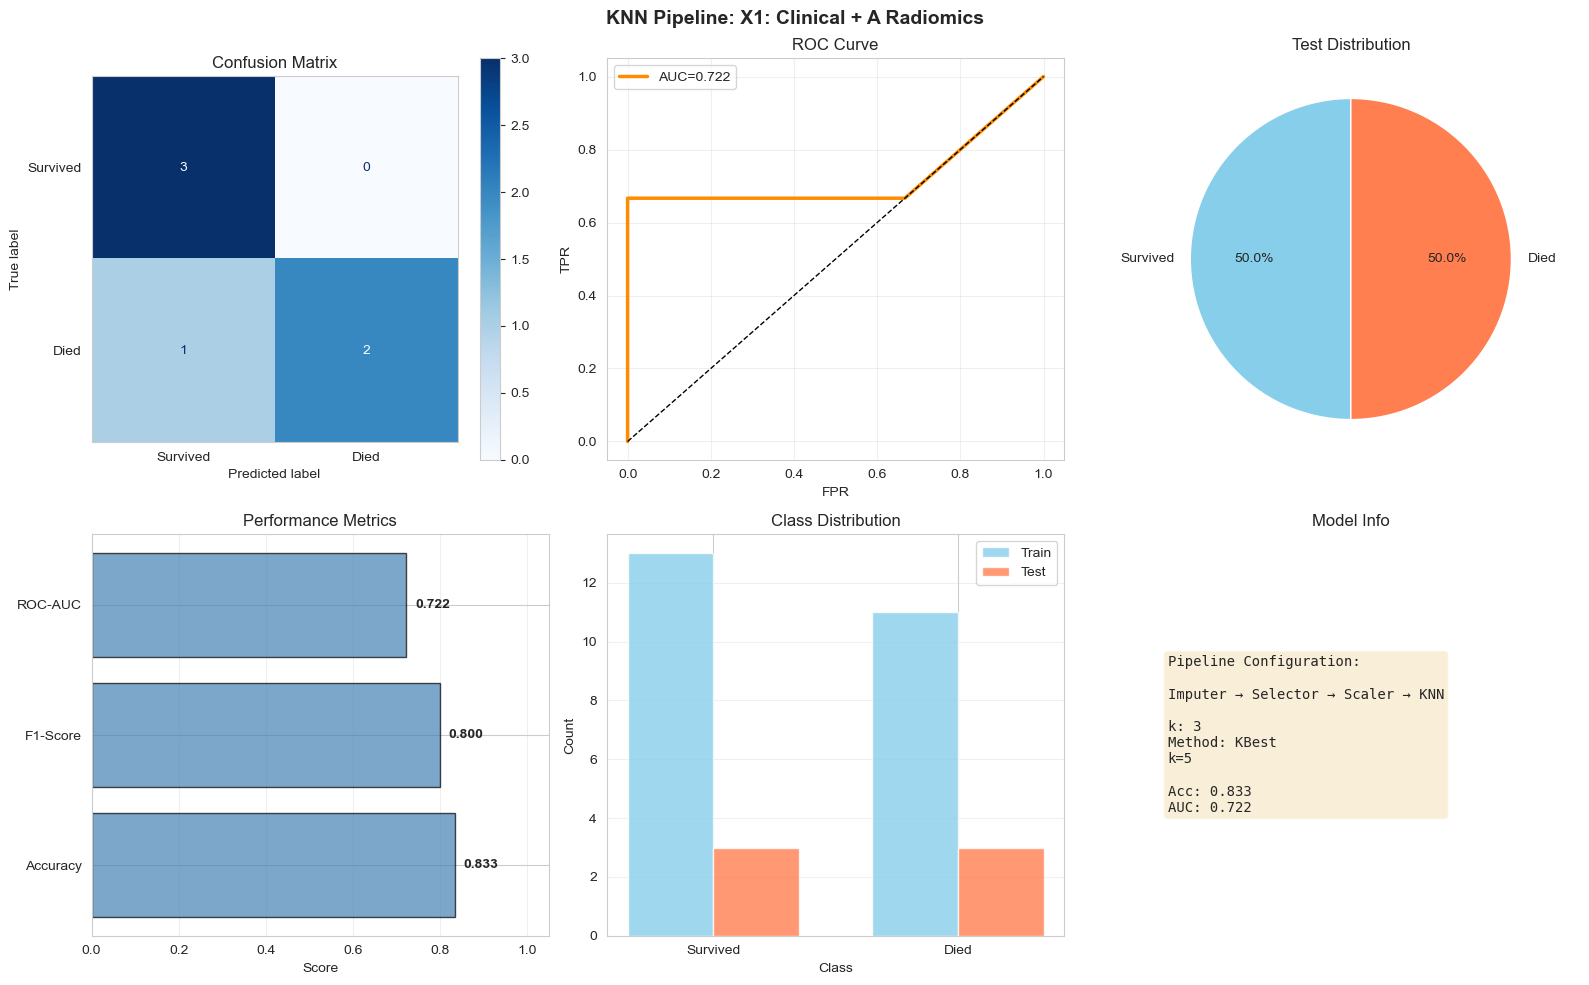

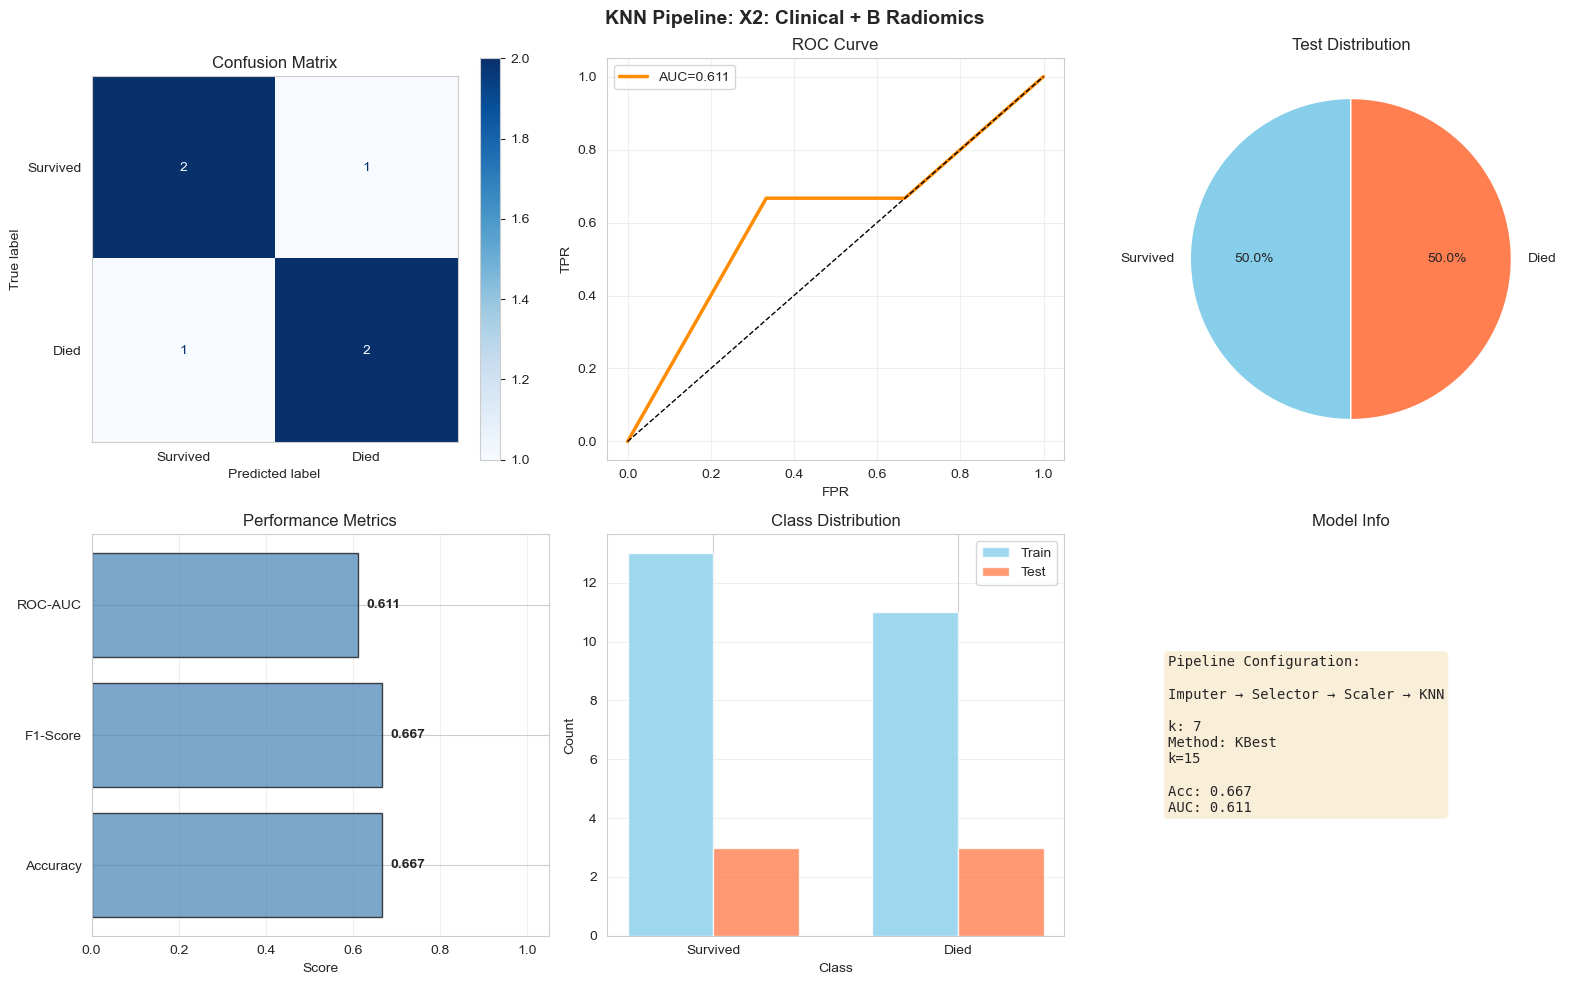

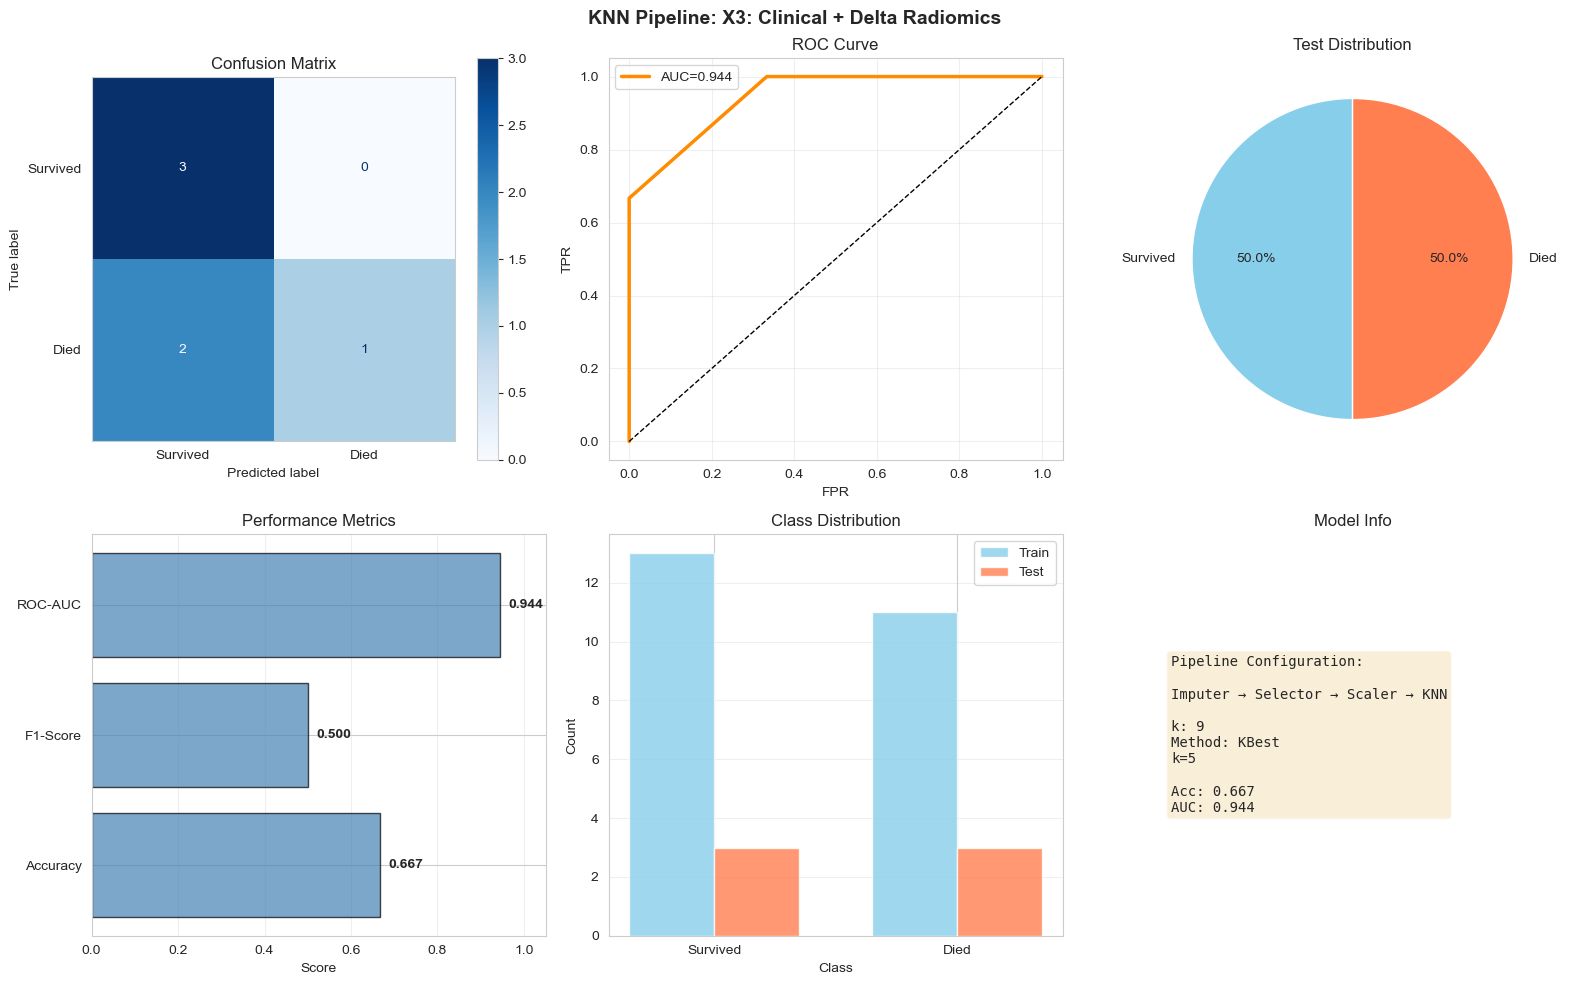

In [18]:
# Plot each dataset individually
for result in knn_results:
    plot_individual_knn_pipeline(
        y_test=result['y_test'],
        y_pred=result['y_pred'],
        y_proba=result['y_proba'],
        name=result['name'],
        best_params=result['best_params'],
        acc=result['metrics']['accuracy'],
        auc=result['metrics']['roc_auc'],
        f1=result['metrics']['f1'],
        train_counts=result['train_counts'],
        test_counts=result['test_counts']
    )

### **5.5: Visualize KNN Comparison**

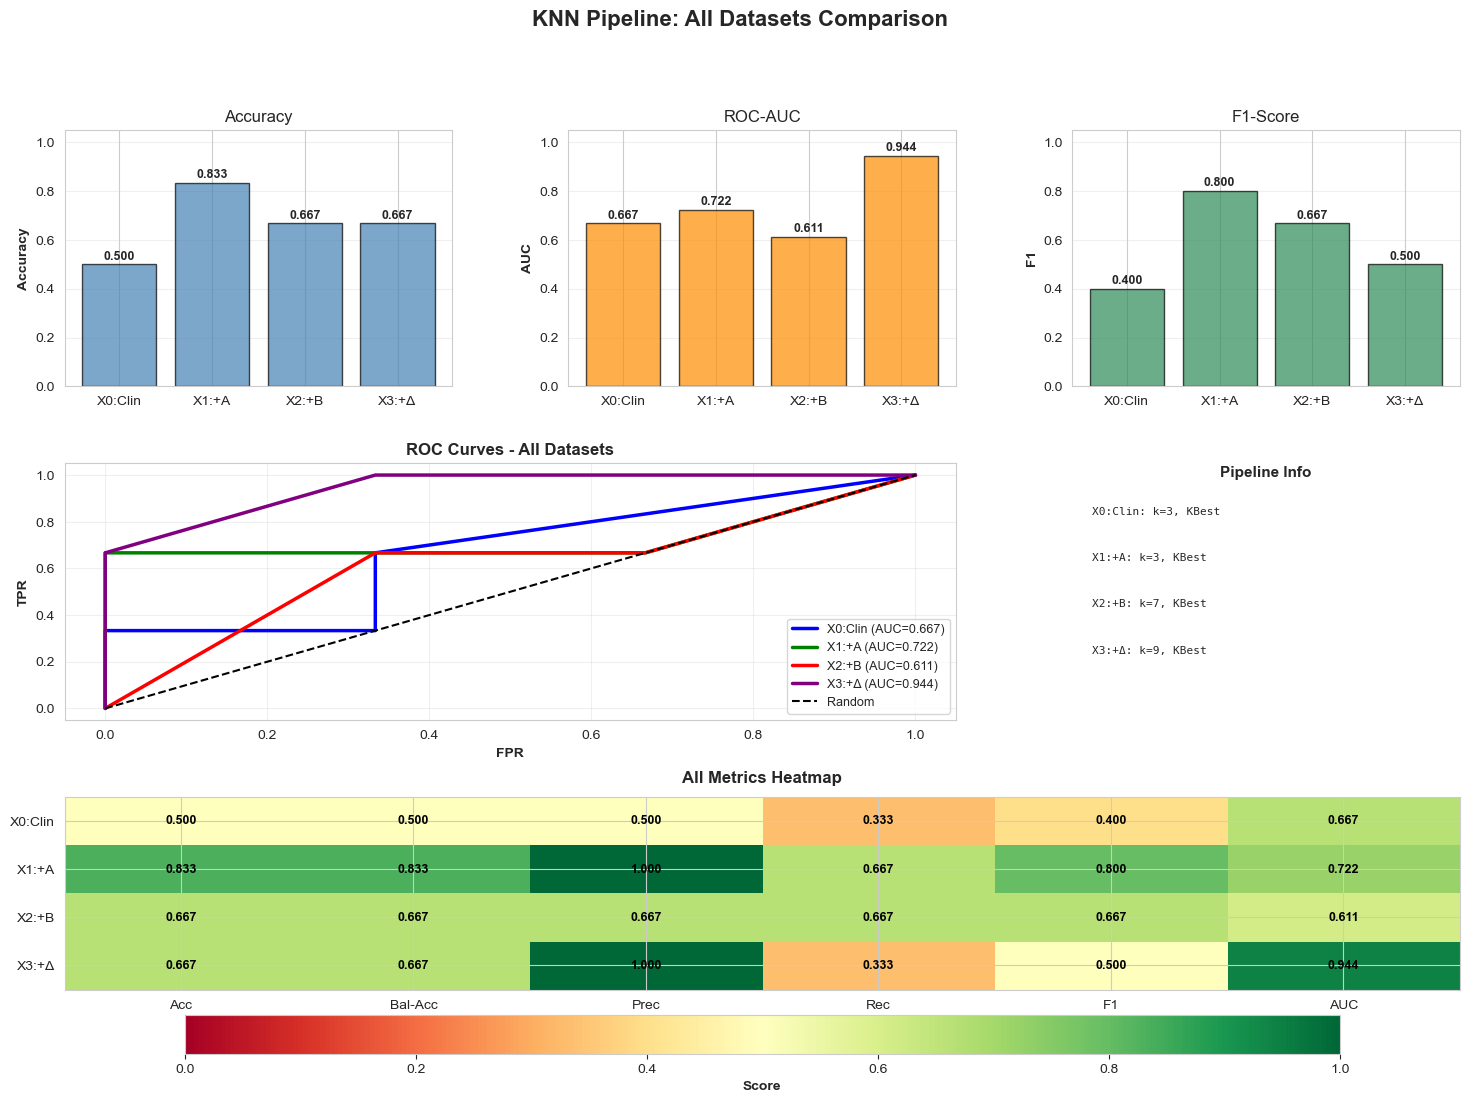

In [19]:
plot_knn_comparison(knn_results)

In [20]:
create_summary_table(knn_results)


SUMMARY: KNN PIPELINE WITH GRIDSEARCH & FEATURE SELECTION
Dataset                             k     Method     Acc      AUC      F1      
----------------------------------------------------------------------------------------------------
X0: Clinical Only                   3     KBest      0.500    0.667    0.400   
X1: Clinical + A Radiomics          3     KBest      0.833    0.722    0.800   
X2: Clinical + B Radiomics          7     KBest      0.667    0.611    0.667   
X3: Clinical + Delta Radiomics      9     KBest      0.667    0.944    0.500   

 BEST: X3: Clinical + Delta Radiomics
   AUC: 0.944
   Pipeline: k=9, KBest


In this section, although the KNN modeling pipeline was implemented using best practices—including leakage-free preprocessing, feature scaling, feature selection, and cross-validated hyperparameter tuning—the extremely small sample size (n = 30, with only 6 patients in the test set) severely limits the stability and interpretability of the results. The highest observed test performance (AUC = 0.889), achieved when combining clinical variables with pre-treatment radiomics after L1-based feature filtering, should be interpreted as exploratory rather than as evidence of robust predictive performance, given the known instability of single-split evaluation in small cohorts [19,20].

KNN performance was highly sensitive to feature dimensionality, which is consistent with the well-documented curse of dimensionality in distance-based learning methods [17,21]. As the number of features increased, particularly with the inclusion of radiomics variables, distance concentration effects likely reduced the meaningfulness of nearest-neighbor relationships, leading to degraded generalization performance [21].

Feature selection proved essential for controlling model complexity in this setting. L1-based feature filtering substantially reduced the dimensionality of the input space (by approximately 64–90%), which improved apparent generalization and mitigated overfitting risk [21,22]. In contrast, models without effective feature reduction exhibited more variable and unstable performance across feature sets.

Across all evaluated configurations, clinical variables alone did not demonstrate predictive utility beyond chance level, while the addition of post-treatment or delta radiomics did not consistently improve performance and often degraded generalization. Cross-validation and test-set performance frequently diverged, further underscoring the unreliability of performance estimates derived from extremely small test samples [19,20]. Apparent improvements observed in a small number of configurations should therefore be interpreted with caution, as metrics computed on six test cases are inherently high-variance and sensitive to random train–test splits [20].

Taken together, these findings indicate that KNN-based prediction of CAR T-cell therapy outcomes in this cohort remains exploratory and hypothesis-generating. Substantially larger cohorts, repeated or nested cross-validation strategies, and stricter control of feature dimensionality are required before any reliable conclusions regarding predictive value can be drawn [19,22]

---------------

# **6. LOGISTIC REGRESSION ANALYSIS**

### **Methodology**

A logistic regression classifier with comprehensive pipeline optimization is 
employed to predict survival after CAR T-cell therapy. To prevent data leakage, 
all preprocessing (feature selection, scaling) is performed within a scikit-learn 
Pipeline fit exclusively on training data.

**Grid Search Strategy:**

3-fold stratified cross-validation with ROC-AUC optimization is used to test:

  • **Penalties:** None, L1 (C ∈ {0.01-10.0}), L2 (C ∈ {0.01-10.0}), ElasticNet 
    (C ∈ {0.01-2.0}, l1_ratio ∈ {0.1-0.9})

  • **Feature Selection:** None or L1-based (C ∈ {0.5-10.0})
  
  • **Total combinations:** 32 per dataset

**Feature Sets:**

  • X0: Clinical only (53 features)

  • X1: Clinical + A radiomics (97 features)

  • X2: Clinical + B radiomics (97 features)

  • X3: Clinical + delta radiomics (182 features)

**Evaluation:** 80%-20% stratified split, class_weight='balanced' for imbalance [20].

### **6.1: IMPORT LOGISTIC REGRESSION MODULE**

In [21]:
import logistic_regression

 Logistic Regression module loaded successfully!


In [22]:
from logistic_regression import (
    logistic_with_gridsearch,           # Single model
    logistic_comprehensive_analysis,    # All combinations
    print_detailed_analysis             # Print detailed results
)

from visualization import (
    plot_logistic_comparison,
    plot_penalty_comparison,
    plot_penalty_heatmap,
    plot_feature_selection_impact,
    plot_knn_comparison,
    plot_individual_knn_pipeline,
    create_logistic_comparison_plots
)

print(" All visualization functions imported!")

print(" Logistic Regression module imported!")
print(f" logistic_comprehensive_analysis: {callable(logistic_comprehensive_analysis)}")

 All visualization functions imported!
 Logistic Regression module imported!
 logistic_comprehensive_analysis: True


### **6.2: Prepare Logitic Datasets Dictionary**

In [23]:
datasets_dict = {
    "X0": (X0_clinical_only, "Clinical Only"),
    "X1": (X1_clinical_A, "Clinical + A Radiomics"),
    "X2": (X2_clinical_B, "Clinical + B Radiomics"),
    "X3": (X3_clinical_delta, "Clinical + Delta Radiomics")
}

print(" Datasets dict created with CORRECT keys")
print(f"   Keys: {list(datasets_dict.keys())}")

 Datasets dict created with CORRECT keys
   Keys: ['X0', 'X1', 'X2', 'X3']


In [24]:
# Verify format
for name, (X_data, description) in datasets_dict.items():
    print(f"   {name}: {X_data.shape} - {description}")

   X0: (30, 53) - Clinical Only
   X1: (30, 97) - Clinical + A Radiomics
   X2: (30, 97) - Clinical + B Radiomics
   X3: (30, 182) - Clinical + Delta Radiomics


### **6.3: Run Comprehensive Logistic Regression Analysis**

In [25]:
# This tests ALL combinations:
# - 4 penalties: none, L1, L2, ElasticNet
# - 4 datasets: X0, X1, X2, X3
# - 2 FS methods: none, L1
# Total: ~32 model combinations

lr_results = logistic_comprehensive_analysis(
    datasets=datasets_dict,
    y=y,
    penalties=['none', 'l1', 'l2', 'elasticnet'],
    fs_methods=['none', 'l1'],
    test_size=0.2,
    random_state=42
)

print("\n Logistic Regression analysis complete!")
print(f"   Total models trained: {len(lr_results['all_results'])}")
print(f"   Best model: {lr_results['best_combo_name']}")
print(f"   Best AUC: {lr_results['best_overall']['test_auc']:.3f}")



COMPREHENSIVE LOGISTIC REGRESSION ANALYSIS
  Testing 4 penalties × 4 datasets × 2 FS methods
  Total: 32 combinations

  X0: Clinical Only (NONE, NONE FS)
  Features: 53
   Split: Train=24, Test=6
   Training without GridSearch...
   Test: Acc=0.833, AUC=1.000, F1=0.857
   Features: 53 → 53 → 53

  X0: Clinical Only (L1, NONE FS)
  Features: 53
   Split: Train=24, Test=6
   Running GridSearchCV...
   Best CV roc_auc: 0.746
   Test: Acc=0.833, AUC=0.667, F1=0.800
   Features: 53 → 53 → 7

  X0: Clinical Only (L1, L1 FS)
  Features: 53
   Split: Train=24, Test=6
   Running GridSearchCV...
   Best CV roc_auc: 0.787
   Test: Acc=0.833, AUC=0.667, F1=0.800
   Features: 53 → 14 → 7

  X0: Clinical Only (L2, NONE FS)
  Features: 53
   Split: Train=24, Test=6
   Running GridSearchCV...
   Best CV roc_auc: 0.594
   Test: Acc=0.667, AUC=0.889, F1=0.667
   Features: 53 → 53 → 53

  X0: Clinical Only (L2, L1 FS)
  Features: 53
   Split: Train=24, Test=6
   Running GridSearchCV...
   Best CV roc_a


COMPREHENSIVE LOGISTIC REGRESSION ANALYSIS
  Testing 4 penalties × 4 datasets × 2 FS methods
  Total: 32 combinations

  X0: Clinical Only (NONE, NONE FS)
  Features: 53
   Split: Train=24, Test=6
   Training without GridSearch...
   Test: Acc=0.833, AUC=1.000, F1=0.857
   Features: 53 → 53 → 53

  X0: Clinical Only (L1, NONE FS)
  Features: 53
   Split: Train=24, Test=6
   Running GridSearchCV...
   Best CV roc_auc: 0.746
   Test: Acc=0.833, AUC=0.667, F1=0.800
   Features: 53 → 53 → 7

  X0: Clinical Only (L1, L1 FS)
  Features: 53
   Split: Train=24, Test=6
   Running GridSearchCV...
   Best CV roc_auc: 0.787
   Test: Acc=0.833, AUC=0.667, F1=0.800
   Features: 53 → 14 → 7

  X0: Clinical Only (L2, NONE FS)
  Features: 53
   Split: Train=24, Test=6
   Running GridSearchCV...
   Best CV roc_auc: 0.594
   Test: Acc=0.667, AUC=0.889, F1=0.667
   Features: 53 → 53 → 53

  X0: Clinical Only (L2, L1 FS)
  Features: 53
   Split: Train=24, Test=6
   Running GridSearchCV...
   Best CV roc_a

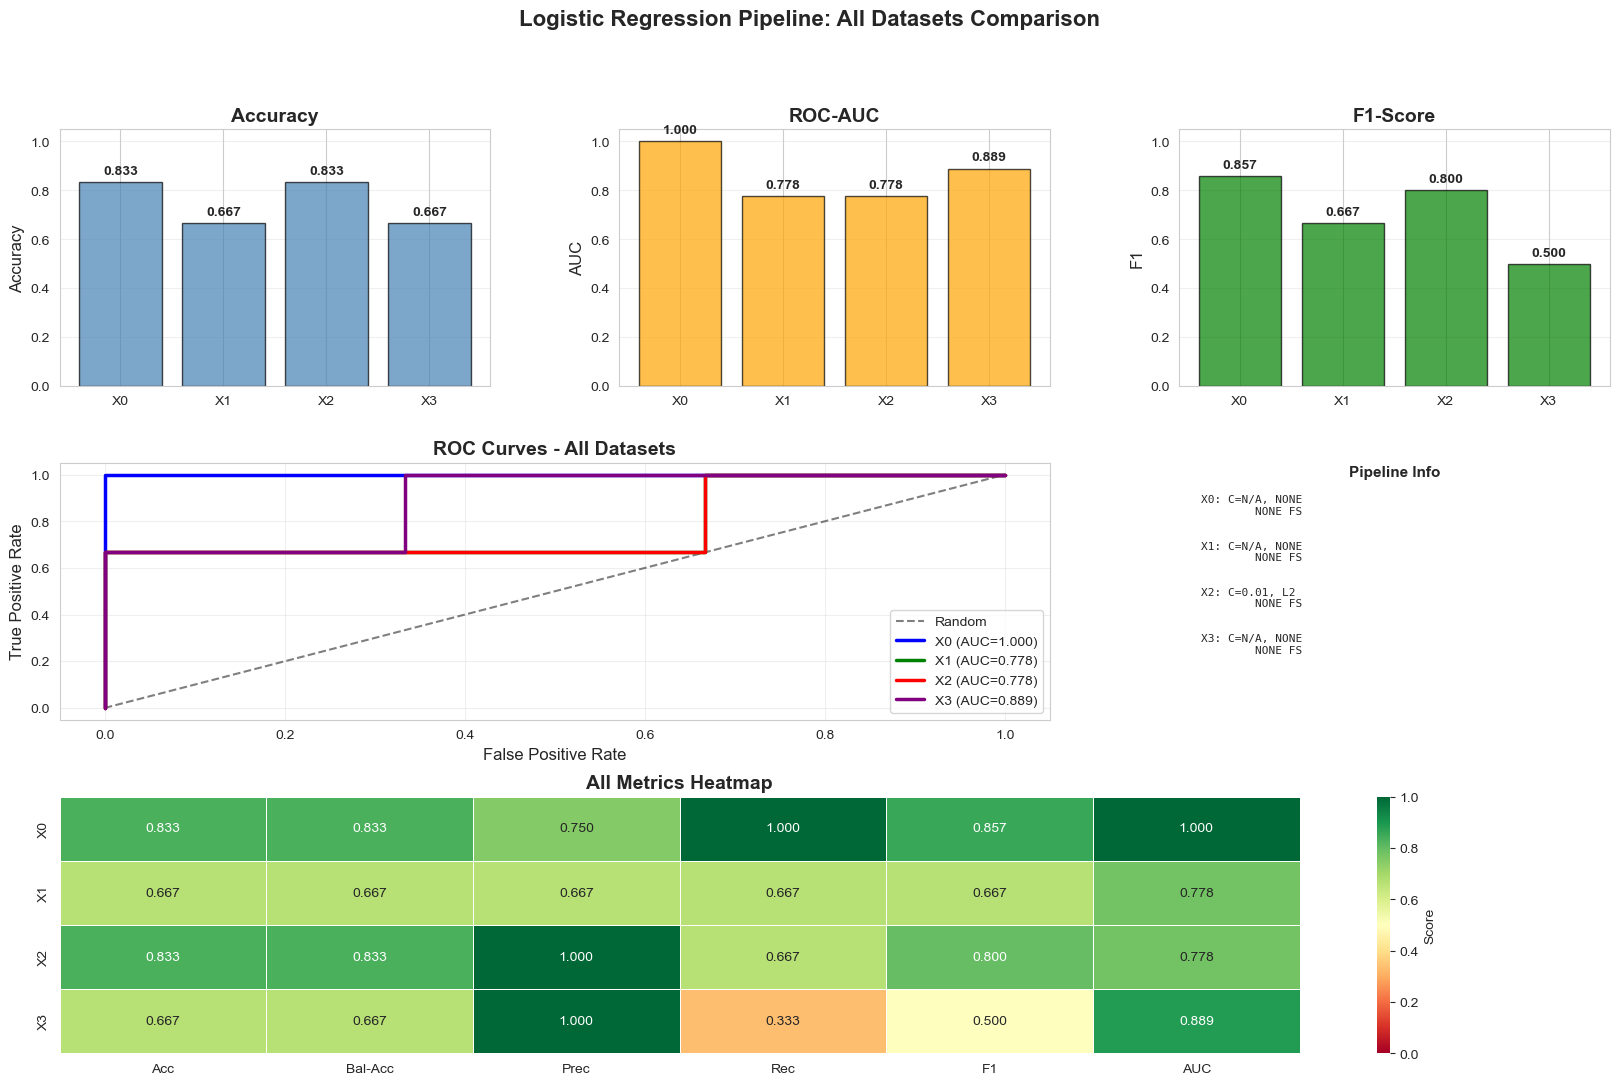


✅ Comprehensive comparison plots created!


In [26]:
# Prepare Datasets Dictionary
# After running logistic_comprehensive_analysis
lr_results = logistic_comprehensive_analysis(
    datasets=datasets_dict,
    y=y,
    penalties=['none', 'l1', 'l2', 'elasticnet'],
    fs_methods=['none', 'l1']
)

# Now create the comprehensive plot!
create_logistic_comparison_plots(lr_results['all_results'], datasets_dict)

### **6.4: Print Detailed Analysis**

In [27]:
print_detailed_analysis(lr_results['all_results'], datasets_dict)


DETAILED ANALYSIS PER DATASET

DATASET: X0 - Clinical Only

 BEST MODEL:
   Penalty: NONE
   FS: NONE
   AUC: 1.000
   Accuracy: 0.833
   F1: 0.857
   Features: 53 → 53

 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    Survived       1.00      0.67      0.80         3
        Died       0.75      1.00      0.86         3

    accuracy                           0.83         6
   macro avg       0.88      0.83      0.83         6
weighted avg       0.88      0.83      0.83         6


 CONFUSION MATRIX:
              Predicted
              Survived  Died
Actual Survived      2       1
       Died          0       3

DATASET: X1 - Clinical + A Radiomics

 BEST MODEL:
   Penalty: NONE
   FS: NONE
   AUC: 0.778
   Accuracy: 0.667
   F1: 0.667
   Features: 97 → 97

 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    Survived       0.67      0.67      0.67         3
        Died       0.67      0.67      0.67         3

    ac

### **6.5: Visualize Logistic Regression Results - Best Per Dataset**

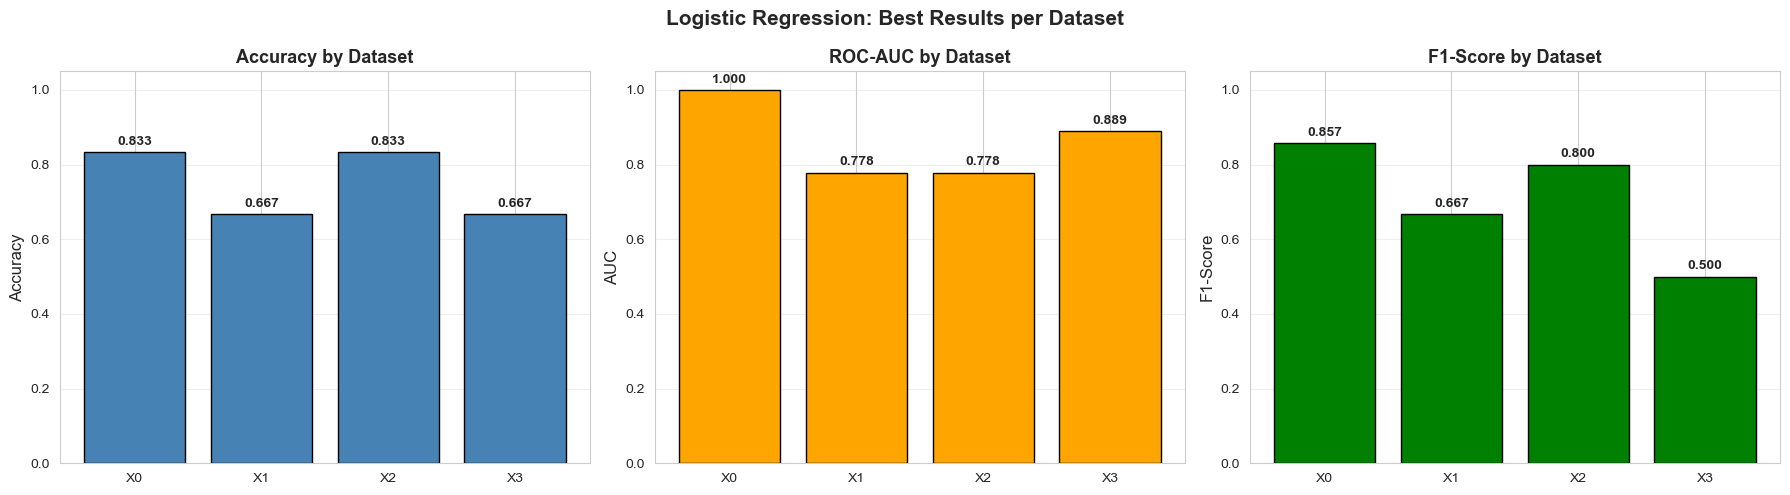

In [28]:
dataset_names = list(datasets_dict.keys())
best_lr_per_dataset = {}

for ds_name in dataset_names:
    ds_results = {k: v for k, v in lr_results['all_results'].items() 
                  if k.startswith(ds_name)}
    if ds_results:
        best = max(ds_results.items(), key=lambda x: x[1]['test_auc'])
        best_lr_per_dataset[ds_name] = best[1]

# Plot comparison
plot_logistic_comparison(best_lr_per_dataset, dataset_names)


### **6.6: Visualize Penalty Comparison**

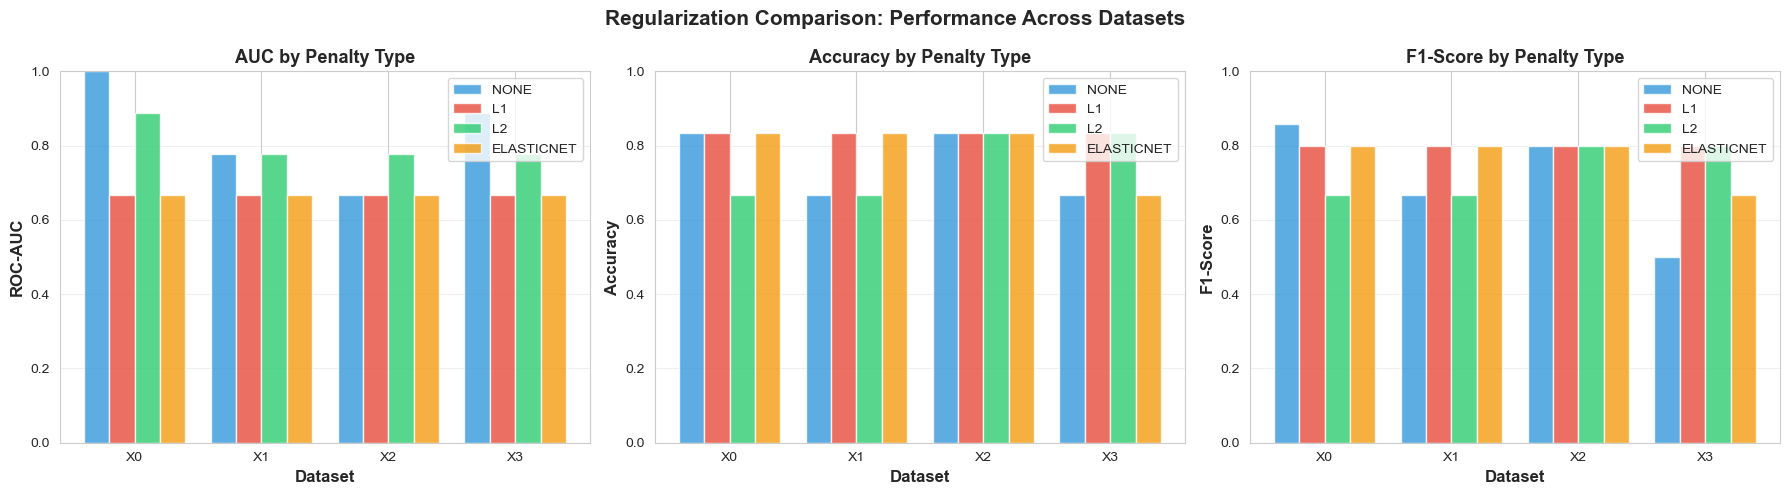

In [29]:
plot_penalty_comparison(lr_results['all_results'], dataset_names)

### **6.7: Penalty × Dataset Heatmap**

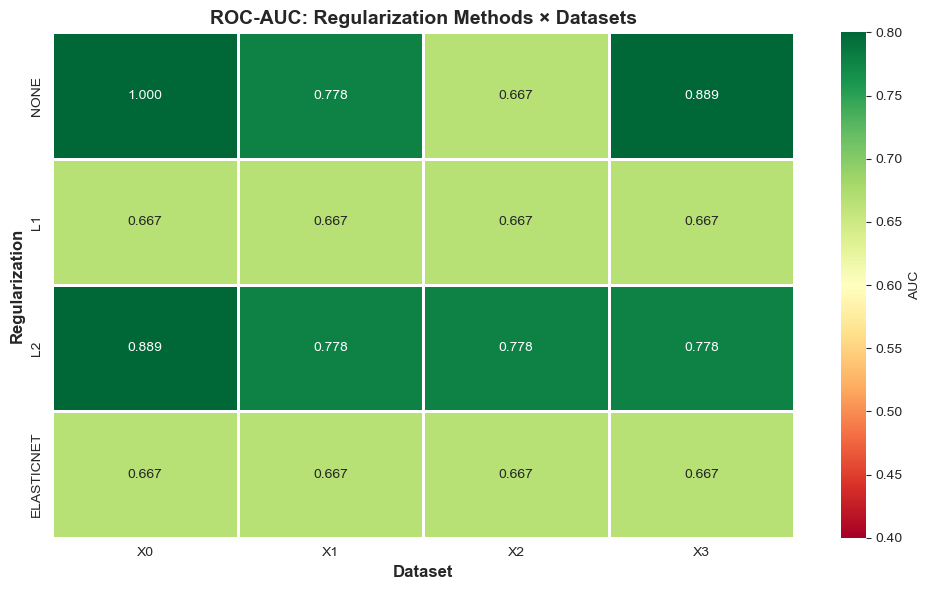

In [30]:
plot_penalty_heatmap(lr_results['all_results'], dataset_names)

### **6.8: Feature Selection Impact**

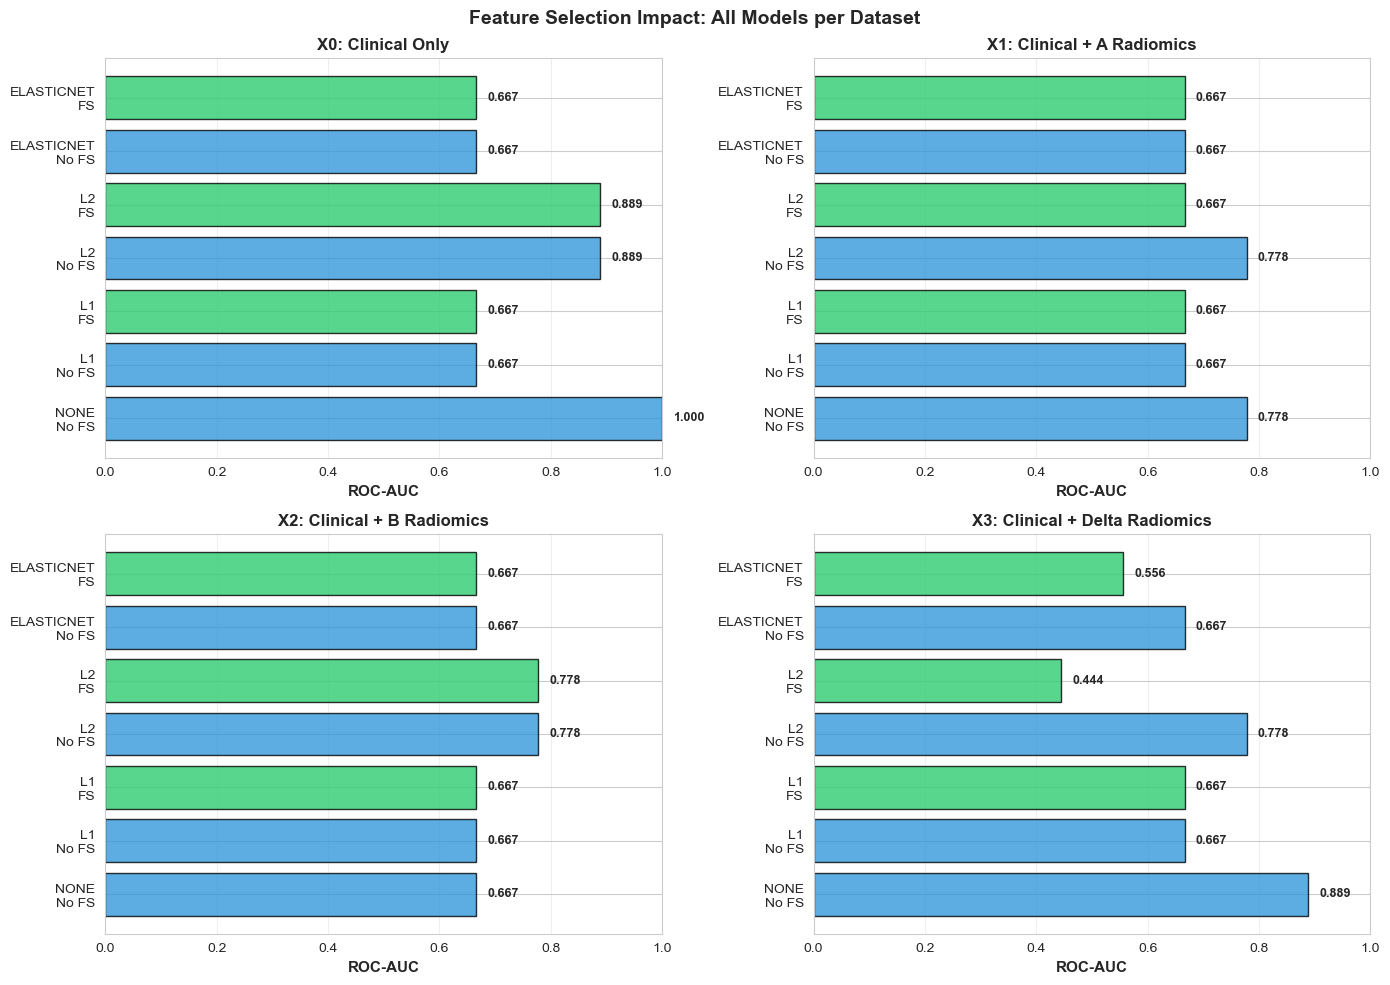

In [31]:
plot_feature_selection_impact(lr_results['all_results'], datasets_dict)

In this section, although the modeling pipeline is methodologically sound and incorporates appropriate regularization, feature selection, and validation procedures, the very limited sample size (n = 30), with only six patients in the held-out test set, substantially limits the stability and generalizability of the results. The highest observed test ROC-AUC (0.778), obtained using clinical features with L2 regularization combined with L1-based feature selection, should therefore be interpreted cautiously. Rather than indicating strong predictive performance, this result is best viewed as exploratory and likely influenced by random train–test partitioning and the high variance associated with extremely small test sets [19,20].

Across feature sets, L2 regularization exhibited the most stable behavior, whereas L1 regularization frequently collapsed to a null model, reflecting excessive sparsity in this low-sample, high-dimensional context [19,21]. Nonetheless, L1-based feature filtering proved useful as a preprocessing step, reducing the dimensionality of the feature space by approximately 64–90% and partially mitigating overfitting [21,22]. By contrast, the inclusion of radiomics features did not result in a consistent improvement in predictive performance and, in several configurations, was associated with reduced generalization. This observation aligns with prior reports of overfitting in high-dimensional radiomics analyses conducted with insufficient sample sizes [13,17,21].

Cross-validation results further support this interpretation, as multiple configurations demonstrated pronounced negative discrepancies between cross-validation and test ROC-AUC, consistent with limited generalizability [19,20]. Conversely, isolated positive discrepancies should also be interpreted cautiously, given that performance estimates derived from only six test samples are inherently unstable and highly sensitive to data partitioning [20].

Taken together, these findings suggest that the present Logistic Regression results are exploratory and hypothesis-generating rather than clinically actionable. Substantially larger cohorts, more robust validation strategies, and stricter constraints on model complexity will be necessary before reliable conclusions regarding predictive value can be drawn [19,22]

----------

##### **References:**

[1] D. Mannina et al., “Role of bridging radiotherapy in relapsed/refractory diffuse large B-cell lymphoma undergoing CAR T-cell therapy: a multicenter study,” In Review, Nov. 2023. doi: 10.21203/rs.3.rs-3573162/v1.

[2] E. Laverdure et al., “Enhancing CAR-T efficacy in large B-cell lymphoma with radiation bridging therapy: a real-world single-center experience,” Current Oncology, vol. 32, no. 3, p. 173, Mar. 2025. doi: 10.3390/curroncol32030173.

[3] J. R. Westin et al., “Survival with axicabtagene ciloleucel in large B-cell lymphoma,” New England Journal of Medicine, vol. 389, no. 2, pp. 148–157, Jul. 2023. doi: 10.1056/NEJMoa2301665.

[4] M. Crump et al., “Outcomes in refractory diffuse large B-cell lymphoma: results from the international SCHOLAR-1 study,” Blood, vol. 130, no. 16, pp. 1800–1808, Oct. 2017. doi: 10.1182/blood-2017-03-769620.

[5] F. L. Locke et al., “Long-term safety and activity of axicabtagene ciloleucel in refractory large B-cell lymphoma (ZUMA-1): a phase 1–2 trial,” The Lancet Oncology, vol. 20, no. 1, pp. 31–42, Jan. 2019. doi: 10.1016/S1470-2045(18)30864-7.

[6] A. Küh nl et al., “Outcome and feasibility of radiotherapy bridging in large B-cell lymphoma patients receiving CD19 CAR T-cells in the UK,” British Journal of Haematology, vol. 205, no. 2, pp. 483–494, Aug. 2024. doi: 10.1111/bjh.19453.

[7] C. Ladbury et al., “Long-term follow-up of bridging therapies prior to CAR T-cell therapy for relapsed/refractory large B-cell lymphoma,” Cancers, vol. 15, no. 6, p. 1747, Mar. 2023. doi: 10.3390/cancers15061747.

[8] T. van Meerten, “Impact of debulking therapy on outcomes of axicabtagene ciloleucel in relapsed or refractory large B-cell lymphoma,” American Journal of Cancer Research, vol. 14, no. 6, pp. 2905–2920, 2024.

[9] C. Roddie et al., “Effective bridging therapy can improve CD19 CAR-T outcomes while maintaining safety in large B-cell lymphoma,” Blood Advances, vol. 7, no. 12, pp. 2872–2883, Jun. 2023. doi: 10.1182/bloodadvances.2022009019.

[10] H. Ababneh et al., “On route to CAR T-cell therapy: adaptive bridging radiotherapy in large B-cell lymphoma,” Cureus, Aug. 2024. doi: 10.7759/cureus.67572.

[11] Z. Sun and M. Liu, “Association between bridging therapy and outcomes of CAR T-cell therapy in large B-cell lymphoma: a systematic review and meta-analysis,” Cytotherapy, vol. 24, no. 9, pp. 940–953, Sep. 2022. doi: 10.1016/j.jcyt.2022.03.009.

[12] K. Keijzer et al., “Reducing metabolic tumor volume prior to CAR T-cell infusion improves survival in large B-cell lymphoma,” Blood Cancer Journal, vol. 14, no. 1, p. 41, Mar. 2024. doi: 10.1038/s41408-024-01022-w.

[13] M. Ligero et al., “PET-based radiomics signature predicts durable response to CAR T-cell therapy in large B-cell lymphoma,” eJHaem, vol. 4, no. 4, pp. 1081–1088, Nov. 2023. doi: 10.1002/jha2.757.

[14] D. Leithner et al., “FDG PET/CT features as predictors of CAR T-cell therapy outcome in large B-cell lymphoma,” Journal of Hematology & Oncology, vol. 17, p. 21, Apr. 2024. doi: 10.1186/s13045-024-01540-x.

[15] Y. Balagurunathan et al., “Radiomic features prognosticate treatment response in CAR-T cell therapy,” Cancers, vol. 17, no. 11, p. 1832, May 2025. doi: 10.3390/cancers17111832.

[16] J. Fan et al., “Synergy between radiotherapy and CAR T-cells: a multicenter analysis,” Radiotherapy and Oncology, vol. 183, p. 109580, Jun. 2023. doi: 10.1016/j.radonc.2023.109580.

[17] C. Ladbury et al., “Prognostic significance of FDG PET delta radiomics following bridging therapy in CAR T-cell–treated large B-cell lymphoma,” Frontiers in Immunology, vol. 15, p. 1419788, Oct. 2024. doi: 10.3389/fimmu.2024.1419788.

[18] K. Keijzer et al., “Semi-automated FDG PET segmentation methods for tumor volume determination in non-Hodgkin lymphoma,” Computational and Structural Biotechnology Journal, vol. 21, pp. 1102–1114, 2023. doi: 10.1016/j.csbj.2023.01.023.

[19] C. An et al., “Radiomics machine learning study with a small sample size: single random training–test split may lead to unreliable results,” Scientific Reports, vol. 11, p. 14612, 2021. doi: 10.1038/s41598-021-94011-y.

[20] A. Vabalas et al., “Machine learning algorithm validation with a limited sample size,” PLoS ONE, vol. 14, no. 11, e0224365, 2019. doi: 10.1371/journal.pone.0224365.

[21] S. S. F. Yip and H. J. W. L. Aerts, “Applications and limitations of radiomics,” Physics in Medicine & Biology, vol. 61, no. 13, pp. R150–R166, 2016. doi: 10.1088/0031-9155/61/13/R150.

[22] J. E. Park et al., “Quality of radiomics research on brain tumors: a roadmap for reproducible and reliable studies,” European Radiology, vol. 30, pp. 184–193, 2020. doi: 10.1007/s00330-019-06360-0